# Jigsaw Multilingual Toxic Comment Classification
>Building a toxic comments classification model using Fastai2 and ULMFiT training approach

Dataset Link: https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification

In [1]:
# imports
from fastai2.text.all import *

import warnings
warnings.filterwarnings('ignore')

## Dataset Download:

In [2]:
%cd ~/Desktop/datasets

/home/harish3110/Desktop/datasets


In [3]:
!kaggle competitions list -s 'jigsaw'

ref                                                deadline             category   reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  --------  -------  ---------  --------------  
jigsaw-multilingual-toxic-comment-classification   2020-06-22 23:59:00  Featured  $50,000       1485            True  
jigsaw-unintended-bias-in-toxicity-classification  2019-07-18 19:35:00  Featured  $65,000       3165           False  
jigsaw-toxic-comment-classification-challenge      2018-03-20 23:59:00  Featured  $35,000       4550            True  


In [4]:
dataset = 'jigsaw-multilingual-toxic-comment-classification'

# !mkdir {dataset}
%cd {dataset}
# !kaggle competitions download -c {dataset}

/home/harish3110/Desktop/datasets/jigsaw-multilingual-toxic-comment-classification


In [5]:
# !ls
# !unzip {dataset + '.zip'}

In [6]:
# Getting rid of .zip file after unzipping its contents
# !rm {dataset + '.zip'}

---

## Basic EDA

In [46]:
%cd ~/Desktop/datasets/jigsaw-multilingual-toxic-comment-classification
!ls

/home/harish3110/Desktop/datasets/jigsaw-multilingual-toxic-comment-classification
jigsaw-toxic-comment-train.csv
jigsaw-toxic-comment-train-processed-seqlen128.csv
jigsaw-unintended-bias-train.csv
jigsaw-unintended-bias-train-processed-seqlen128.csv
models
sample_submission.csv
test.csv
test-processed-seqlen128.csv
validation.csv
validation-processed-seqlen128.csv


In [8]:
df_train = pd.read_csv('jigsaw-toxic-comment-train.csv')
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_ar...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [9]:
len(df_train)

223549

In [10]:
df = df_train[['comment_text', 'toxic']].copy()
df.columns = ['text', 'label'] # Fastai needs in this format
df.head()

,text,label
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_ar...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


---

## Creating Dataloader

Creating a dataloader for self-supervised learning task which tries to predict the next word in a sequence as represented by `text_` below. 

Fastai handles text processing steps like tokenization and numericalization internally when `TextBlock` is passed to `DataBlock`

In [13]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(0.1)
)

In [14]:
dls_lm = dls_lm.dataloaders(df, bs=64, seq_len=80)

# select bs mostly based on how much your GPU can handle without running out of memory

In [15]:
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos "" 2010 ( utc ) \n▁ : : i changed it to "" "" american accent "" "" . xxmaj the book it 's taken from is a history book , not a linguistics book , and ca n't be considered a reliable source for linguistic questions . xxmaj the authors obviously do n't know what a xxmaj boston accent sounds like , and anyhow where would he have gotten a xxmaj boston accent , having grown up in",""" 2010 ( utc ) \n▁ : : i changed it to "" "" american accent "" "" . xxmaj the book it 's taken from is a history book , not a linguistics book , and ca n't be considered a reliable source for linguistic questions . xxmaj the authors obviously do n't know what a xxmaj boston accent sounds like , and anyhow where would he have gotten a xxmaj boston accent , having grown up in xxmaj"
1,"field is used for in the info box ( see template : infobox university ) , please do not re - add until consensus exists for this . king ( edits ) "" xxbos xxmaj what is interesting is how the rule applies to me only , and not the 4 edits by more than one editor . xxmaj so the rule only works when there is one editor , and not a team of 2 . xxmaj that is","is used for in the info box ( see template : infobox university ) , please do not re - add until consensus exists for this . king ( edits ) "" xxbos xxmaj what is interesting is how the rule applies to me only , and not the 4 edits by more than one editor . xxmaj so the rule only works when there is one editor , and not a team of 2 . xxmaj that is an"
2,"is my page , so i should be able to edit it how i wish . xxbos xxmaj after checking the history and the logs some more , i have asked that the page be indefinitely semi - protected , we 'll see what happens … xxbos "" , i and — preceding undated comment added \n\n▁ , i and ( talk ⋅ contribs ) xxmaj we do not care that xxup wikinews even considers xxmaj dr . xxmaj rafizadeh","my page , so i should be able to edit it how i wish . xxbos xxmaj after checking the history and the logs some more , i have asked that the page be indefinitely semi - protected , we 'll see what happens … xxbos "" , i and — preceding undated comment added \n\n▁ , i and ( talk ⋅ contribs ) xxmaj we do not care that xxup wikinews even considers xxmaj dr . xxmaj rafizadeh as"


## Fine-tuning Language Model

Fine-tuning Wikitext 103 based LM to toxic comments dataset using ULMFiT methodologies. This fine-tuned LM can thus be used as the base to classify toxic texts in the next step. 

In [15]:
#fine-tuning wikitext LM to Jigsaw dataset

learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [16]:
# The above process takes time so better to save and keep it for later immediate use
learn.save('learner')

In [16]:
learn.load('learner')

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.010964781977236271)

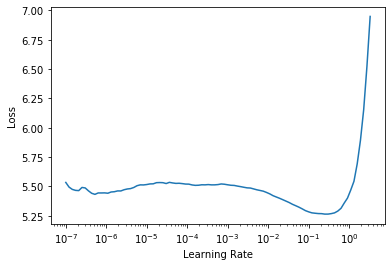

In [17]:
learn.lr_find()

Let's train the last layer of the model using a learning rate of `1e-2` based on the above learning rate finder plot using Leslie Smith's [1 Cycle Training](https://arxiv.org/abs/1708.07120) approach.

In [18]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.020530,3.810608,0.327028,45.177883,11:14


In [19]:
# Save for later ease of use
learn.save('1epoch')

In [17]:
learn = learn.load('1epoch')

Now train the entire model after unfreezing all the layers

In [18]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.706767,3.522639,0.360908,33.873688,11:41
1,3.626278,3.494178,0.365380,32.923199,11:41
2,3.595659,3.466114,0.370988,32.012096,11:43
3,3.504905,3.439640,0.374389,31.175734,11:45
4,3.406405,3.424658,0.376581,30.712149,11:42
5,3.390948,3.411916,0.379264,30.323282,11:43
6,3.329405,3.403355,0.381306,30.064802,11:43
7,3.253695,3.396538,0.382453,29.860537,11:46
8,3.229122,3.397871,0.382954,29.900368,11:41
9,3.212680,3.400255,0.382863,29.971733,11:49


Once we have fine-tuned out LM to our downstream task, we save the encoder part of the model which is all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. 

We can then use this encoder part as our base to build a toxic comment classification model. 

In [19]:
learn.save_encoder('finetuned')

## Text Generation

**Disclaimer**: The generated text will be toxic.

In [23]:
TEXT = "go to hell"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [24]:
print("\n".join(preds))

go to hell you bitch Do not see a problem with this article . It is not a WP : coatrack , the WP : fringe based problem is already covered in the article . Multi
go to hell you loser . 
▁ You 're a gay homo There are thousands of ways you can improve the quality of the article . You have very much to read . i have just checked the article


## Training the classifier

### Creating the classifier dataloader

Ensure that the sequence length and vocab passed to the `TextBlock` is same as that given while fine-tuning LM 

In [18]:
blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock())
dls = DataBlock(blocks=blocks,
                      get_x=ColReader('text'),
                      get_y=ColReader('label'),
                      splitter=RandomSplitter(0.3))

In [19]:
dls = dls.dataloaders(df, bs=64)

In [20]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxunk \n▁ xxup xxunk , xxunk , 5 , \n▁ xxunk , 1200 , , xxup lo , xxunk , xxunk , 20 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , \n▁ xxunk , 1800 , , xxup td , xxunk , xxunk , 25 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 , - xxrep 3 9 ,",0
1,xxbos xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup fat xxup jew xxup,1
2,xxbos xxup wikipedia xxup loves xxup me . xxup they xxup like xxup to xxup censor xxup me . xxup communism xxup is xxup censorship . xxup wikipedia xxup is xxup communism . \n xxup wikipedia xxup loves xxup me . xxup they xxup like xxup to xxup censor xxup me . xxup communism xxup is xxup censorship . xxup wikipedia xxup is xxup communism . \n xxup wikipedia xxup loves xxup me . xxup they xxup like xxup to xxup censor xxup me . xxup communism xxup is xxup censorship . xxup wikipedia xxup is xxup communism . \n xxup wikipedia xxup loves xxup me . xxup they xxup like xxup to xxup censor xxup me . xxup communism xxup is xxup censorship . xxup wikipedia xxup is xxup communism . \n xxup wikipedia xxup loves xxup me . xxup they xxup like xxup to xxup censor xxup me,1


### Defining the learner

In [21]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
learn.load_encoder('finetuned')

### Training the classifier

In [22]:
learn.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(60008, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(60008, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True

In [23]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.276889,0.149792,0.938969,01:37


SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=1.9054607491852948e-06)

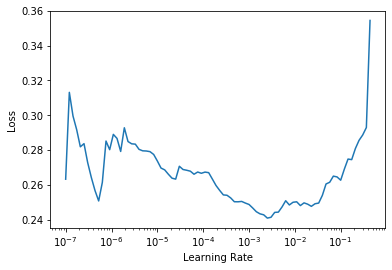

In [27]:
learn.freeze_to(-2)
learn.lr_find()

In [28]:
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.126002,0.117519,0.952717,01:58


SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=1.5848931980144698e-06)

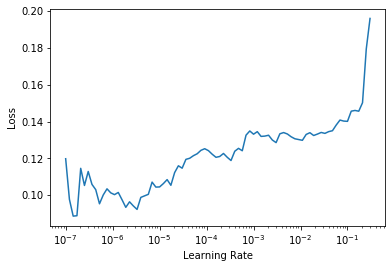

In [29]:
learn.freeze_to(-3)
learn.lr_find()

In [30]:
learn.fit_one_cycle(1, slice(1e-6/(2.6**4),1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.145981,0.118907,0.952061,02:31


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.0964781722577754e-06)

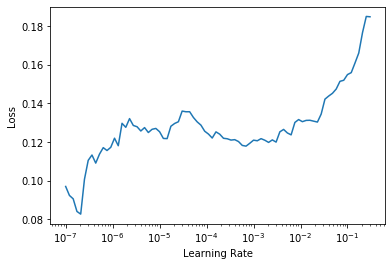

In [31]:
learn.unfreeze()
learn.lr_find()

In [32]:
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.112858,0.102257,0.957414,03:29
1,0.113077,0.101430,0.958681,03:27


In [35]:
learn.save('toxic_classifier_final')

### Applying Test Time Augmentation(TTA)

In [36]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9586812853813171

---
---